In [2]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
import math
from scipy.stats import norm
import joblib
import matplotlib.colors as mcolors

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

FileNotFoundError: [Errno 2] No such file or directory

In [42]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroModel(config)

    return model

def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

def get_centers(p_emb, s_emb, m_emb, train_labels):
    p_centers, s_centers, m_centers, all_centers = [], [], [], []

    for i in range(10):
        ind = train_labels == i
    
        p_center = p_emb[ind].mean(axis=0)
        p_center = p_center / p_center.norm()
        p_centers.append(p_center)
    
        s_center = s_emb[ind].mean(axis=0)
        s_center = s_center / s_center.norm()
        s_centers.append(s_center)
    
        m_center = m_emb[ind].mean(axis=0)
        m_center = m_center / m_center.norm()
        m_centers.append(m_center)

        all_emb = (p_emb + s_emb + m_emb) / 3
        all_center = all_emb[ind].mean(axis=0)
        all_center = all_center / all_center.norm()
        all_centers.append(all_center)
    
    p_centers = torch.stack(p_centers)
    s_centers = torch.stack(s_centers)
    m_centers = torch.stack(m_centers)
    all_centers = torch.stack(all_centers)

    return p_centers, s_centers, m_centers, all_centers

def plot_obj_umap(dataset, idx, embeddings, targets):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))

    obj_embedding = embeddings[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    axs[1].plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        axs[2].scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                       color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)

    axs[2].scatter(obj_embedding[0], obj_embedding[1], color=palette[targets[idx]], edgecolors='black', alpha=1.0, s=5 * marker_size)
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    axs[2].legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    
    
    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()

In [8]:
org_train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
org_val = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')
org_test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

org_train = org_train[['id', 'l', 'b']]
org_val = org_val[['id', 'l', 'b']]
org_test = org_test[['id', 'l', 'b']]

combined_df = pd.concat([org_train, org_val, org_test])
id2lb = combined_df.set_index('id')[['l', 'b']].T.to_dict('list')

run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

model = get_model(config)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [9]:
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

val_dataset = PSMDataset(config, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
val_p_emb, val_s_emb, val_m_emb, val_labels = get_embs(val_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

p_centers, s_centers, m_centers, all_centers = get_centers(train_p_emb, train_s_emb, train_m_emb, train_labels)

train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
val_emb = (val_p_emb + val_s_emb + val_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

umap = joblib.load('umap.pkl')
train_umap = umap.transform(train_emb)
val_umap = umap.transform(val_emb)
test_umap = umap.transform(test_emb)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.74s/it]


In [16]:
config['file'] = 'preprocessed_data/full_lb/spectra_and_v'
config['classes'] = ['LSP', 'ROT:', 'DCEP', 'VAR', 'SRD', 'DCEPS', 'RRD', 'CWA', 'CWB']

new_train = PSMDataset(config, split='train')
new_train_dataloader = DataLoader(new_train, batch_size=config['batch_size'], shuffle=False)
new_train_p_emb, new_train_s_emb, new_train_m_emb, new_train_labels = get_embs(new_train_dataloader)
new_train_emb = (new_train_p_emb + new_train_s_emb + new_train_m_emb) / 3
new_train_umap = umap.transform(new_train_emb)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


In [71]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 
marker_size = 12

new_id2target = new_train.id2target
new_target2id = new_train.target2id
new_palette = sns.color_palette("hls", len(new_id2target))
new_palette[3], new_palette[-1] = new_palette[-1], new_palette[3] 

In [72]:
new_palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7178666666666667, 0.33999999999999997),
 (0.6554666666666664, 0.86, 0.33999999999999997),
 (0.86, 0.33999999999999997, 0.6554666666666664),
 (0.33999999999999997, 0.86, 0.7178666666666667),
 (0.33999999999999997, 0.6554666666666664, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.7178666666666661, 0.33999999999999997, 0.86),
 (0.33999999999999997, 0.86, 0.3712)]

In [68]:
def plot_one_embs_new_classes(embeddings, targets, new_embeddings, new_targets):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=targets, cmap=mcolors.ListedColormap(palette), alpha=0.3, s=marker_size)
    plt.scatter(new_embeddings[:, 0], new_embeddings[:, 1], c=new_targets, cmap=mcolors.ListedColormap(new_palette), 
                edgecolors='black', alpha=1.0, s=3 * marker_size)

    unique_labels = np.unique(targets)
    handles_colors = [mlines.Line2D([], [], color=palette[label], marker='o', linestyle='None', markersize=8, 
                    label=id2target[label]) for label in unique_labels]
    
    unique_new_labels = np.unique(new_targets)
    new_handles_colors = [mlines.Line2D([], [], color=new_palette[label], marker='o', linestyle='None', markersize=8, 
                                        label=new_id2target[label]) for label in unique_new_labels]

    combined_legend = handles_colors + new_handles_colors
    plt.legend(handles=combined_legend, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

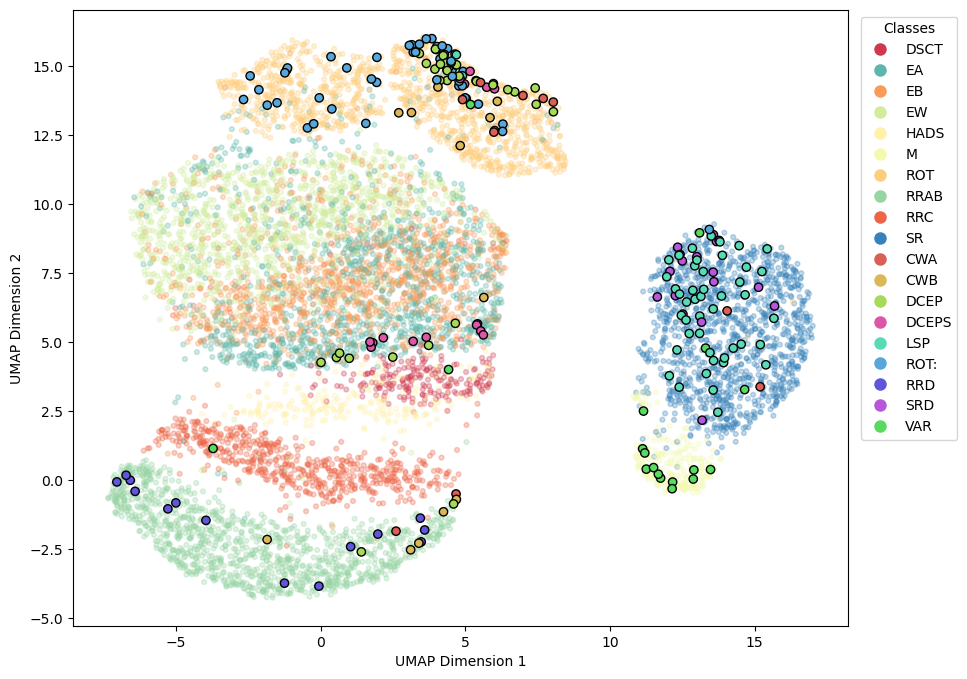

In [73]:
plot_one_embs_new_classes(train_umap, train_labels, new_train_umap, new_train_labels)

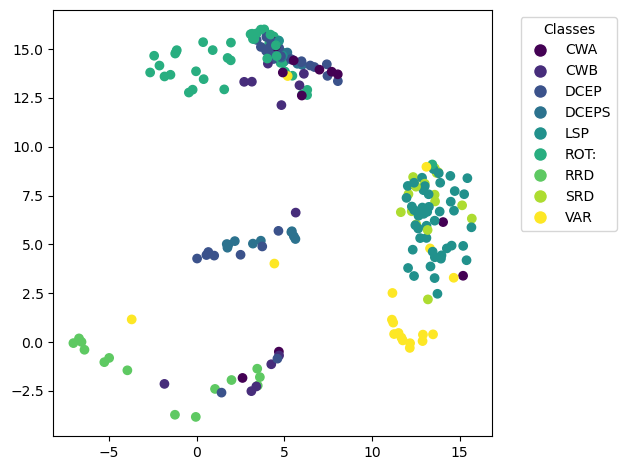

In [31]:
scatter = plt.scatter(new_train_umap[:, 0], new_train_umap[:, 1], c=new_train_labels, cmap='viridis', alpha=1.0)

unique_labels = np.unique(new_train_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', label=new_train.id2target[label],
                      markersize=10, markerfacecolor=plt.cm.viridis(scatter.norm(label))) 
           for label in unique_labels]

plt.legend(handles=handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
plot_obj_umap(test_dataset, 120, test_umap, test_labels)

214

In [28]:
new_train.id2target

{0: 'CWA',
 1: 'CWB',
 2: 'DCEP',
 3: 'DCEPS',
 4: 'LSP',
 5: 'ROT:',
 6: 'RRD',
 7: 'SRD',
 8: 'VAR'}

In [10]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')

In [11]:
df['target'].value_counts()

target
EW       597
SR       479
EA       272
RRAB     231
EB       207
ROT      189
RRC       93
M         30
HADS      29
DSCT      25
ROT:       9
LSP        6
DCEP       4
CWB        2
DSCT:      2
CWA        2
SRD        1
RRD        1
YSO        1
SXPHE      1
UG         1
UV         1
VAR        1
Name: count, dtype: int64